In [46]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
to_run = True
if to_run:
    os.chdir('..')
    to_run = False
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\tumle\Desktop\UniFiles
c:\Users\tumle\Desktop


In [47]:
import pandas as pd
import pm4py
from pm4py.objects.dcr.obj import DcrGraph
from pm4py.objects.log.obj import EventLog, Trace

In [ ]:
A, B, C, D, E, F, G, H, I, J = "A", "B", "C", "D", "E", "F", "G", "H", "I", "J"

log_og = [[A, C, D],
       [A, B, G],
       [A, C, D, E, H, B, J, I, B, H, J, I, B, H, G],
       [A, H, E, I, G],
       [A, C, D, E, H, B, J, I, H, B, G],
       [A, B, H, J, I, H, J, I, G],
       [A, F, H, J, I, H, J, I, H, G],
       [A, C, D, E, H, J, I, H, G],
       [A, B, H, J, I, H, J, I, H, J, G],
       [A, C, D, E, H, J, G],
       [A, F, H, J, I, H, J, G], 
       [A, B, H, J, I, H, B, J, I, H, G],
       [A, C, G],
       [A, C, D, E, H, B, J, I, B, H, J, I, B, H, G],
       [A, H, E, J, G],
       [A, C, D, E, H, J, I, H, J, I, G],
       [A, B, H, J, I, H, J, I, G],
       [A, F, H, J, I, H, J, I, H, G],
       [A, C, D, E, H, J, I, H, G],
       [A, B, H, J, I, H, J, I, H, J, G],
       [A, F, H, J, I, H, J, G],
       [A, B, H, J, I, H, J, I, H, G],
       [A, C, D, G],
       [A, C, D, E, H, B, J, I, B, H, J, I, B, H, G],
       [A, H, E, I, G],
       [A, C, D, E, H, B, J, I, H, B, G],
       [A, B, H, J, I, H, J, I, G],
       [A, F, H, J, I, H, J, I, H, G],
       [A, C, D, E, H, J, I, H, G],
       [A, B, H, J, I, H, J, I, H, J, G],
       [A, F, H, J, I, H, J, G],
       [A, B, H, J, I, H, J, I, H, G],
       [A, C, G],
       [A, C, D, E, H, B, J, I, B, H, J, I, B, H, G],
       [A, H, E, J, G],
       [A, C, D, E, H, J, I, H, J, I, G],
       [A, B, H, J, I, H, J, I, G],
       [A, F, H, J, I, H, J, I, H, G],
       [A, C, D, E, H, J, I, H, G],
       [A, B, H, J, I, H, J, I, H, J, G],
       [A, F, H, J, I, H, J, G]]

print(len(log_og))

log = EventLog()
for trace_list in log_og:
    trace = Trace()
    for event_name in trace_list:
        event = pm4py.objects.log.obj.Event()
        event["concept:name"] = event_name
        trace.append(event)
    log.append(trace)

41


In [49]:
def check_trace_conformance(trace, graph):
    """
    Manually checks if a single trace is conformant with a DCR graph.
    Returns: Boolean (True if satisfied, False otherwise)
    """
    # Copy them to avoid modifying the original graph
    included = set(graph.marking.included)
    pending = set(graph.marking.pending)
    executed = set(graph.marking.executed)
    
    # Record events in the graph
    graph_events = graph.events

    # Replay the Trace
    for event_dict in trace:
        event = event_dict['concept:name']
        
        # Assumption: Ignore events not in the graph
        if event not in graph_events:
            continue
        
        # Event must be Included
        if event not in included:
            return False # Violation: Event is excluded
        
        # Condition holds if: The condition event is Excluded OR it has been Executed
        conditions = graph.conditions.get(event, set())
        for condition_event in conditions:
            if condition_event in included and condition_event not in executed:
                return False # Violation: Condition not met
        
        # Apply DCR semantics
        # Update Executed
        executed.add(event)
        
        # Update Pending
        if event in pending:
            pending.remove(event)
            
        # Apply Responses (A *-> B, B becomes pending)
        responses = graph.responses.get(event, set())
        for response_event in responses:
            pending.add(response_event)
            
        # Apply Includes (A +-> B, B becomes included) - Doesn't matter for part 1
        includes = graph.includes.get(event, set())
        for include_event in includes:
            included.add(include_event)
            
        # Apply Excludes (A %-> B, B becomes excluded)
        excludes = graph.excludes.get(event, set())
        for exclude_event in excludes:
            if exclude_event in included:
                included.remove(exclude_event)

    # Check Accepting State
    # The trace is satisfied ONLY IF there are no events that are both Included and Pending, i.e., no unfinished business
    final_obligations = pending.intersection(included)
    
    if len(final_obligations) > 0:
        return False # Trace finished with pending obligations
    
    return True

In [50]:
def count_satisfied_traces(event_log, dcr_graph):
    """
    Counts all the satisfied traces in an event log dataframe that a DCR graph satisfies

    returns:
        satisfied_count(int) integer repressenting all satisfied traces
        conformance_results(list[dict{is_fit(bool), trace(<Trace Object>)}]) The Trace object is given by the log_converter
    """
    satisfied_count = 0
    conformance_results = []

    for trace in event_log:
        # Run our custom check
        is_fit = check_trace_conformance(trace, dcr_graph)
        
        if is_fit:
            satisfied_count += 1
            
        conformance_results.append({
            'is_fit': is_fit,
            'trace': trace
        })

    return satisfied_count, conformance_results

In [51]:
def create_base_dcr(events):
    """
    Function for creating a dcr graph base with every event added, labels added, label_map added, and every event included

    Input: List(string)

    Returns: HierarchicalDcrGraph()
    """
    g = DcrGraph()
    for event in events:
        g.events.add(event)
        g.labels.add(event)
        g.label_map[event] = event
        g.marking.included.add(event) # Initially, only these are allowed
    return g

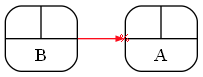

Traces satisfied: 41


In [52]:
# Model 1
events1 = [A, B]
graph1 = create_base_dcr(events1)

graph1.excludes[B] = {A}
pm4py.view_dcr(graph1)

count1, conformance1 = count_satisfied_traces(log, graph1)
print(f"Traces satisfied: {count1}")

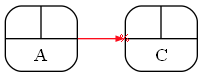

Traces satisfied: 24


In [53]:
# Model 2
events2 = [A, C]
graph2 = create_base_dcr(events2)

graph2.excludes[A] = {C}
pm4py.view_dcr(graph2)

count2, conformance2 = count_satisfied_traces(log, graph2)
print(f"Traces satisfied: {count2}")

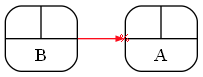

Traces satisfied: 41


In [54]:
# Model 3
events3 = [A, B]
graph3 = create_base_dcr(events3)

graph3.excludes[B] = {A}
pm4py.view_dcr(graph3)

count3, conformance3 = count_satisfied_traces(log, graph3)
print(f"Traces satisfied: {count3}")

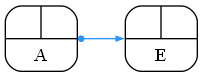

Traces satisfied: 17


In [55]:
# Model 4
events4 = [A, E]
graph4 = create_base_dcr(events4)

graph4.responses[A] = {E}

pm4py.view_dcr(graph4)

count4, conformance4 = count_satisfied_traces(log, graph4)
print(f"Traces satisfied: {count4}")

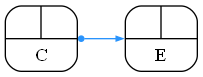

Traces satisfied: 37


In [56]:
# Model 5
events5 = [C, E]
graph5 = create_base_dcr(events5)

graph5.responses[C] = {E}

pm4py.view_dcr(graph5)

count5, conformance5 = count_satisfied_traces(log, graph5)
print(f"Traces satisfied: {count5}")

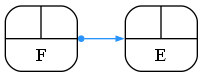

Traces satisfied: 33


In [57]:
# Model 6
events6 = [F, E]
graph6 = create_base_dcr(events6)

graph6.responses[F] = {E}

pm4py.view_dcr(graph6)

count6, conformance6 = count_satisfied_traces(log, graph6)
print(f"Traces satisfied: {count6}")

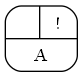

Traces satisfied: 41


In [58]:
# Model 7
events7 = [A]
graph7 = create_base_dcr(events7)

graph7.marking.pending.add(A)

pm4py.view_dcr(graph7)

count7, conformance7 = count_satisfied_traces(log, graph7)
print(f"Traces satisfied: {count7}")

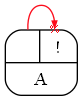

Traces satisfied: 41


In [59]:
# Model 8
events8 = [A]
graph8 = create_base_dcr(events8)

graph8.marking.pending.add(A)
graph8.excludes[A] = {A}

pm4py.view_dcr(graph8)

count8, conformance8 = count_satisfied_traces(log, graph8)
print(f"Traces satisfied: {count8}")

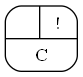

Traces satisfied: 17


In [60]:
# Model 9
events9 = [C]
graph9 = create_base_dcr(events9)

graph9.marking.pending.add(C)

pm4py.view_dcr(graph9)

count9, conformance9 = count_satisfied_traces(log, graph9)
print(f"Traces satisfied: {count9}")

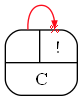

Traces satisfied: 17


In [61]:
# Model 10
events10 = [C]
graph10 = create_base_dcr(events10)

graph10.marking.pending.add(C)
graph10.excludes[C] = {C}

pm4py.view_dcr(graph10)

count10, conformance10 = count_satisfied_traces(log, graph10)
print(f"Traces satisfied: {count10}")

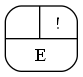

Traces satisfied: 17


In [62]:
# Model 11
events11 = [E]
graph11 = create_base_dcr(events11)

graph11.marking.pending.add(E)

pm4py.view_dcr(graph11)

count11, conformance11 = count_satisfied_traces(log, graph11)
print(f"Traces satisfied: {count11}")

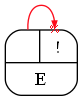

Traces satisfied: 17


In [63]:
# Model 12
events12 = [E]
graph12 = create_base_dcr(events12)

graph12.marking.pending.add(E)
graph12.excludes[E] = {E}

pm4py.view_dcr(graph12)

count12, conformance12 = count_satisfied_traces(log, graph12)
print(f"Traces satisfied: {count12}")

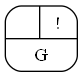

Traces satisfied: 40


In [64]:
# Model 13
events13 = [G]
graph13 = create_base_dcr(events13)

graph13.marking.pending.add(G)

pm4py.view_dcr(graph13)

count13, conformance13 = count_satisfied_traces(log, graph13)
print(f"Traces satisfied: {count13}")

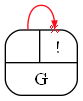

Traces satisfied: 40


In [65]:
# Model 14
events14 = [G]
graph14 = create_base_dcr(events14)

graph14.marking.pending.add(G)
graph14.excludes[G] = {G}

pm4py.view_dcr(graph14)

count14, conformance14 = count_satisfied_traces(log, graph14)
print(f"Traces satisfied: {count14}")

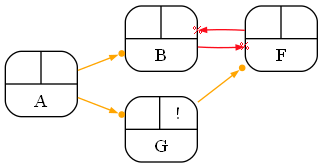

Traces Satisfied: 32


In [66]:
# Model 15
events15 = [A, B, F, G]
graph15 = create_base_dcr(events15)

graph15.conditions[B] = {A}
graph15.conditions[G] = {A}
graph15.marking.pending.add(G)
graph15.conditions[F] = {G}
graph15.excludes[B] = {F}
graph15.excludes[F] = {B}

pm4py.view_dcr(graph15)

count15, conformance15 = count_satisfied_traces(log, graph15)
print(f"Traces Satisfied: {count15}")

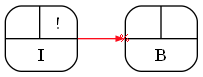

Traces satisfied: 26


In [67]:
# Model 16
events16 = [I, B]
graph16 = create_base_dcr(events16)

graph16.marking.pending.add(I)
graph16.excludes[I] = {B}

pm4py.view_dcr(graph16)

count16, conformance16 = count_satisfied_traces(log, graph16)
print(f"Traces satisfied: {count16}")